In [0]:
# tft_backtest_save.py (paste into Jupyter cell)
%matplotlib inline
import os, glob, math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Repro
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# -------- config --------
DATA_FOLDER = r"C:\Users\sohan\Downloads\archive (1)"  # update
OUTPUT_ROOT = "outputs_tft"
os.makedirs(OUTPUT_ROOT, exist_ok=True)

INPUT_WINDOW = 30
OUTPUT_WINDOW = 1   # t+1 forecasting
HIDDEN_SIZE = 128
NUM_HEADS = 4
BATCH_SIZE = 64
EPOCHS = 50
LR = 1e-3
PATIENCE = 8
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

EPS = 1e-9  # for MAPE

# -------- dataset & model (same structure) --------
class TimeSeriesDataset(Dataset):
    def __init__(self, series, input_window=30, output_window=1):
        self.series = np.asarray(series, dtype=float)
        self.input_window = int(input_window)
        self.output_window = int(output_window)

    def __len__(self):
        return max(0, len(self.series) - self.input_window - self.output_window + 1)

    def __getitem__(self, idx):
        x = self.series[idx:idx+self.input_window]
        y = self.series[idx+self.input_window: idx+self.input_window+self.output_window]
        x = torch.tensor(x, dtype=torch.float32).unsqueeze(-1)  # (input_window,1)
        y = torch.tensor(y, dtype=torch.float32)               # (output_window,)
        return x, y

class TFTBlock(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_heads=4, output_size=1, dropout=0.1):
        super().__init__()
        if hidden_size % num_heads != 0:
            raise ValueError("hidden_size must be divisible by num_heads.")
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=2, dropout=dropout)
        self.attn = nn.MultiheadAttention(hidden_size, num_heads, batch_first=True)
        self.layernorm = nn.LayerNorm(hidden_size)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)                            # (batch, seq, hidden)
        attn_out, attn_weights = self.attn(lstm_out, lstm_out, lstm_out)
        x = self.layernorm(attn_out + lstm_out)
        x = self.dropout(torch.relu(self.fc1(x)))
        out = self.fc_out(x)   # (batch, seq, output_size)
        return out, attn_weights

# -------- train / rolling / helpers --------
def train_tft(series, input_window=30, output_window=1,
              hidden_size=128, num_heads=4, lr=1e-3,
              epochs=50, batch_size=64, device='cpu', patience=8):
    device = torch.device(device)
    mean = np.mean(series)
    std = np.std(series) + 1e-9
    series_scaled = (np.asarray(series) - mean) / std

    ds = TimeSeriesDataset(series_scaled, input_window=input_window, output_window=output_window)
    if len(ds) == 0:
        raise ValueError("Series too short for windows.")
    loader = DataLoader(ds, batch_size=batch_size, shuffle=True, drop_last=False)

    model = TFTBlock(input_size=1, hidden_size=hidden_size, num_heads=num_heads, output_size=output_window)
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', patience=3, factor=0.5)
    crit = nn.MSELoss()

    best_loss = float('inf'); no_imp=0; best_state=None
    for epoch in range(1, epochs+1):
        model.train(); total_loss=0.0
        for x,y in loader:
            x = x.to(device); y = y.to(device)
            opt.zero_grad()
            out, _ = model(x)
            pred = out[:, -1, :]        # last time-step
            loss = crit(pred, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            total_loss += loss.item() * x.size(0)
        avg_loss = total_loss / len(ds)
        sched.step(avg_loss)
        print(f"Epoch {epoch}/{epochs} avg_loss={avg_loss:.6f}")
        if avg_loss + 1e-9 < best_loss:
            best_loss = avg_loss
            best_state = {k:v.cpu().clone() for k,v in model.state_dict().items()}
            no_imp=0
        else:
            no_imp +=1
            if no_imp >= patience:
                print("Early stopping")
                break
    if best_state is not None:
        model.load_state_dict(best_state)
    return model, mean, std

def rolling_forecast(series, model, mean, std, input_window=30, device='cpu', sample_attention_steps=3):
    device = torch.device(device)
    model.to(device); model.eval()
    series = np.asarray(series, dtype=float)
    series_scaled = (series - mean) / std
    preds = []
    attn_samples = {}
    n_steps = max(0, len(series_scaled) - input_window)
    # sample indices for attention saving (start, mid, end) limited by availability
    sample_indices = sorted(list({0, max(0,(n_steps//2)-1), max(0,n_steps-1)}))[:sample_attention_steps]
    with torch.no_grad():
        for t in range(n_steps):
            x = torch.tensor(series_scaled[t:t+input_window], dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)
            out, attn = model(x)
            pred_scaled = out[0, -1, :].cpu().numpy()
            pred = pred_scaled * std + mean
            preds.append(pred)
            if t in sample_indices:
                attn_samples[t] = attn[0].cpu().numpy()
    preds = np.array(preds)   # (n_steps, output_window)
    return preds, attn_samples

def compute_metrics(actual, preds):
    # actual: series[input_window : input_window + n_steps + (output_window-1)]
    actual = np.asarray(actual)
    preds = np.asarray(preds)
    # select first horizon
    y_true = actual[:, 0] if actual.ndim>1 else actual
    y_pred = preds[:, 0]
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + EPS))) * 100
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, mape, r2

# -------- main loop over files --------
all_metrics = []
csv_files = sorted(glob.glob(os.path.join(DATA_FOLDER, "*.csv")))
csv_files = [f for f in csv_files if "HEALTHCARE" not in os.path.basename(f).upper()]

for filepath in csv_files:
    try:
        sector = os.path.splitext(os.path.basename(filepath))[0]
        print("\nProcessing", sector)
        df = pd.read_csv(filepath)
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.sort_values('Date').reset_index(drop=True)
        series = df['Close'].values.astype(float)

        # train
        model, mean, std = train_tft(series, input_window=INPUT_WINDOW, output_window=OUTPUT_WINDOW,
                                     hidden_size=HIDDEN_SIZE, num_heads=NUM_HEADS,
                                     lr=LR, epochs=EPOCHS, batch_size=BATCH_SIZE, device=DEVICE, patience=PATIENCE)

        # rolling forecast
        preds, attn_samples = rolling_forecast(series, model, mean, std, input_window=INPUT_WINDOW, device=DEVICE)

        # align actuals for metrics
        n_steps = preds.shape[0]
        actuals = []
        for i in range(n_steps):
            actuals.append(series[INPUT_WINDOW + i : INPUT_WINDOW + i + OUTPUT_WINDOW])
        actuals = np.array(actuals)  # shape (n_steps, output_window)

        # metrics
        mae, rmse, mape, r2 = compute_metrics(actuals, preds)
        print(f"{sector} - MAE {mae:.4f} RMSE {rmse:.4f} MAPE {mape:.3f}% R2 {r2:.6f}")

        # save per-sector outputs
        out_dir = os.path.join(OUTPUT_ROOT, sector)
        os.makedirs(out_dir, exist_ok=True)
        pd.DataFrame(preds, columns=[f"pred_h{h+1}" for h in range(preds.shape[1])]).to_csv(os.path.join(out_dir, "preds.csv"), index=False)
        pd.DataFrame(actuals, columns=[f"true_h{h+1}" for h in range(actuals.shape[1])]).to_csv(os.path.join(out_dir, "trues.csv"), index=False)
        torch.save(model.state_dict(), os.path.join(out_dir, "model_checkpoint.pt"))
        # save attention samples (small number)
        for t, att in attn_samples.items():
            np.save(os.path.join(out_dir, f"attn_step_{t}.npy"), att)

        # save simple plot actual vs pred (t+1)
        plt.figure(figsize=(12,4))
        start = INPUT_WINDOW
        plt.plot(df['Date'], df['Close'], label='Actual', color='black')
        plt.plot(df['Date'].iloc[start : start + n_steps], preds[:,0], label='Pred (t+1)', color='red', alpha=0.8)
        plt.title(f"{sector} — Actual vs TFT Pred (t+1)")
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(out_dir, "actual_vs_pred_t+1.png"), dpi=200)
        plt.close()

        # append metrics
        all_metrics.append({
            "sector": sector, "mae_t+1": float(mae), "rmse_t+1": float(rmse),
            "mape_t+1": float(mape), "r2_t+1": float(r2), "n_steps": int(n_steps)
        })

    except Exception as e:
        print("ERROR", filepath, e)

# save master csv and two comparison plots
if len(all_metrics) > 0:
    master = pd.DataFrame(all_metrics)
    master.to_csv(os.path.join(OUTPUT_ROOT, "all_metrics_tft.csv"), index=False)
    print("Master metrics saved:", os.path.join(OUTPUT_ROOT, "all_metrics_tft.csv"))

    # MAPE barplot
    plt.figure(figsize=(10,6))
    sns.barplot(x="mape_t+1", y="sector", data=master.sort_values("mape_t+1"), palette="mako")
    plt.xlabel("MAPE (%)"); plt.title("TFT t+1 MAPE by Sector")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_ROOT, "mape_bar_tft.png"), dpi=200)
    plt.close()

    # RMSE-MAE scatter
    plt.figure(figsize=(8,6))
    plt.scatter(master['rmse_t+1'], master['mae_t+1'])
    for i, r in master.iterrows():
        plt.text(r['rmse_t+1'], r['mae_t+1'], r['sector'], fontsize=8)
    plt.xlabel("RMSE"); plt.ylabel("MAE"); plt.title("RMSE vs MAE (t+1) across sectors")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_ROOT, "rmse_mae_scatter_tft.png"), dpi=200)
    plt.close()

else:
    print("No metrics generated.")



Processing NIFTY 50_cleaned
Epoch 1/50 avg_loss=0.063307
Epoch 2/50 avg_loss=0.010575
Epoch 3/50 avg_loss=0.007186
Epoch 4/50 avg_loss=0.006190
Epoch 5/50 avg_loss=0.006181
Epoch 6/50 avg_loss=0.006172
Epoch 7/50 avg_loss=0.006758
Epoch 8/50 avg_loss=0.006297
Epoch 9/50 avg_loss=0.006107
Epoch 10/50 avg_loss=0.006628
Epoch 11/50 avg_loss=0.005075
Epoch 12/50 avg_loss=0.005942
Epoch 13/50 avg_loss=0.005877
Epoch 14/50 avg_loss=0.006623
Epoch 15/50 avg_loss=0.006361
Epoch 16/50 avg_loss=0.004960
Epoch 17/50 avg_loss=0.004635
Epoch 18/50 avg_loss=0.004825
Epoch 19/50 avg_loss=0.004442
Epoch 20/50 avg_loss=0.004800
Epoch 21/50 avg_loss=0.004486
Epoch 22/50 avg_loss=0.004711
Epoch 23/50 avg_loss=0.004445
Epoch 24/50 avg_loss=0.004498
Epoch 25/50 avg_loss=0.004205
Epoch 26/50 avg_loss=0.004090
Epoch 27/50 avg_loss=0.004350
Epoch 28/50 avg_loss=0.004252
Epoch 29/50 avg_loss=0.004339
Epoch 30/50 avg_loss=0.004123
Epoch 31/50 avg_loss=0.004118
Epoch 32/50 avg_loss=0.004141
Epoch 33/50 avg_loss

C:\Users\sohan\AppData\Local\Temp\ipykernel_18612\4027393768.py:227: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="mape_t+1", y="sector", data=master.sort_values("mape_t+1"), palette="mako")


C:\Users\sohan\AppData\Local\Temp\ipykernel_18612\304053396.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(x="mape_t+1", y="sector_short", data=df_mape, palette="mako")


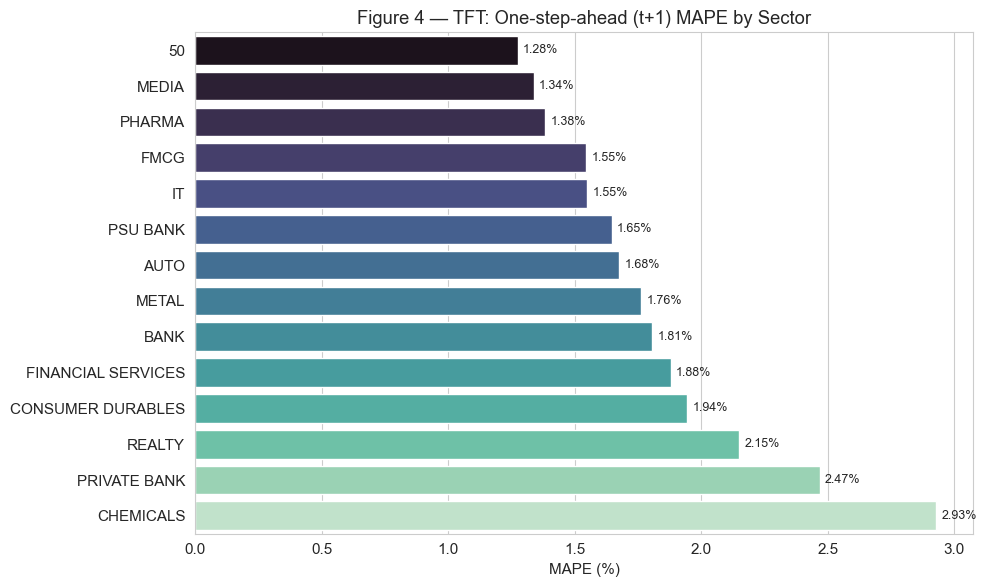

Saved MAPE barplot to: figures_tft\tft_mape_barplot.png


C:\Users\sohan\AppData\Local\Temp\ipykernel_18612\304053396.py:60: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="rmse_t+1", y="mae_t+1", data=df, s=100, palette="tab10")


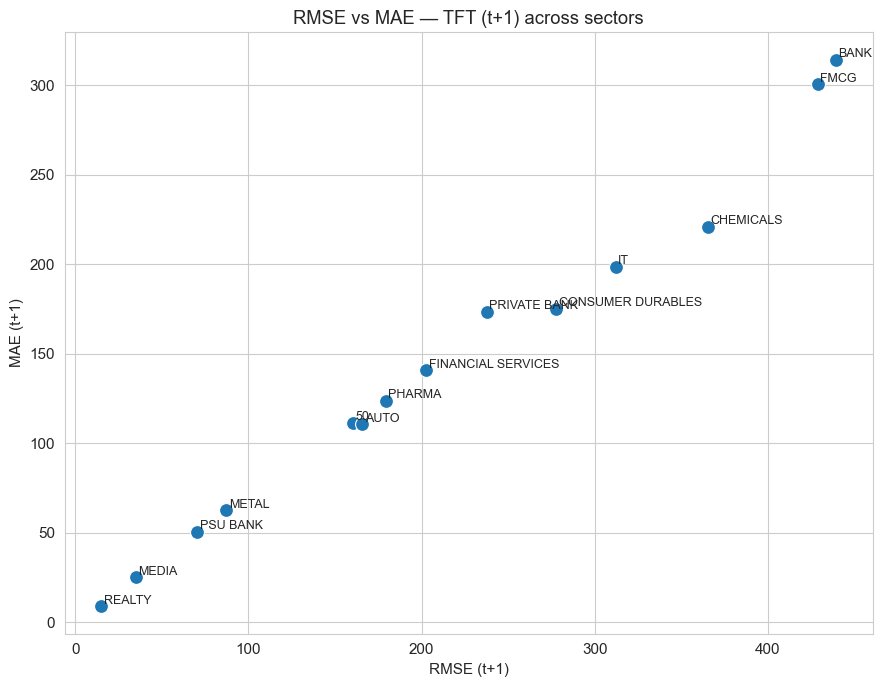

Saved RMSE-MAE scatter to: figures_tft\tft_rmse_mae_scatter.png


In [1]:
# Jupyter cell: TFT MAPE barplot + RMSE vs MAE scatter
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Put TFT results here (from your table) ---
data = [
    ("NIFTY NIFTY50_cleaned", 111.4154969, 160.3846468, 1.275764804, 0.999285444, 4574),
    ("NIFTY AUTO_cleaned", 110.6687528, 165.8587653, 1.675955902, 0.999191309, 4574),
    ("NIFTY BANK_cleaned", 314.2777663, 439.2560782, 1.807019371, 0.999027311, 4574),
    ("NIFTY CHEMICALS_cleaned", 220.9374181, 365.3404923, 2.92941563, 0.998360489, 4574),
    ("NIFTY CONSUMER DURABLES_cleaned", 175.2177107, 277.5840471, 1.944769827, 0.999372753, 4574),
    ("NIFTY FINANCIAL SERVICES_cleaned", 140.8249514, 202.6821626, 1.879744655, 0.999073448, 4574),
    ("NIFTY FMCG_cleaned", 300.5361518, 428.7659703, 1.546199128, 0.999265473, 4574),
    ("NIFTY IT_cleaned", 198.6623413, 312.096815, 1.549576691, 0.999246277, 4574),
    ("NIFTY MEDIA_cleaned", 25.18335006, 34.8257422, 1.337539398, 0.996251125, 4574),
    ("NIFTY METAL_cleaned", 62.63654206, 87.20758399, 1.76330709, 0.998150496, 4574),
    ("NIFTY PHARMA_cleaned", 123.5507237, 179.1636025, 1.384628739, 0.998784903, 4574),
    ("NIFTY PRIVATE BANK_cleaned", 173.2556843, 237.6336189, 2.468993172, 0.998982858, 4574),
    ("NIFTY PSU BANK_cleaned", 50.59065127, 70.41051186, 1.648086515, 0.997185302, 4574),
    ("NIFTY REALTY_cleaned", 8.94296853, 15.14011138, 2.150051316, 0.997528096, 4574),
]

cols = ["sector", "mae_t+1", "rmse_t+1", "mape_t+1", "r2_t+1", "n_steps"]
df = pd.DataFrame(data, columns=cols)

# Optional: make prettier sector names for plotting
df['sector_short'] = df['sector'].str.replace('_cleaned','').str.replace('NIFTY ','').str.replace('_',' ')

# Create output dir
out_dir = "figures_tft"
os.makedirs(out_dir, exist_ok=True)

# --- Figure 4: MAPE barplot (sorted ascending) ---
plt.rcParams.update({"font.size": 11})
df_mape = df.sort_values("mape_t+1", ascending=True).reset_index(drop=True)

plt.figure(figsize=(10,6))
sns.set_style("whitegrid")
bar = sns.barplot(x="mape_t+1", y="sector_short", data=df_mape, palette="mako")
plt.xlabel("MAPE (%)")
plt.ylabel("")
plt.title(" TFT: One-step-ahead (t+1) MAPE by Sector")

# annotate exact values on bars
for i, (val) in enumerate(df_mape["mape_t+1"]):
    bar.text(val + 0.02, i, f"{val:.2f}%", va='center', fontsize=9)

plt.tight_layout()
mape_path = os.path.join(out_dir, "tft_mape_barplot.png")
plt.savefig(mape_path, dpi=300, bbox_inches="tight")
plt.show()

print("Saved MAPE barplot to:", mape_path)

# --- Optional figure: RMSE vs MAE scatter with labels ---
plt.figure(figsize=(9,7))
sns.scatterplot(x="rmse_t+1", y="mae_t+1", data=df, s=100, palette="tab10")
for i, r in df.iterrows():
    plt.text(r['rmse_t+1'] + 1.5, r['mae_t+1'] + 1.5, r['sector_short'], fontsize=9)
plt.xlabel("RMSE (t+1)")
plt.ylabel("MAE (t+1)")
plt.title("RMSE vs MAE — TFT (t+1) across sectors")
plt.grid(True)
plt.tight_layout()
scatter_path = os.path.join(out_dir, "tft_rmse_mae_scatter.png")
plt.savefig(scatter_path, dpi=300, bbox_inches="tight")
plt.show()

print("Saved RMSE-MAE scatter to:", scatter_path)
